In [ ]:
!pip install skl2onnx
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.4/298.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.2 which is incompatible.
tensorflow 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.20.2 w

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.1 MB/s eta 0:00:00


In [ ]:
import os

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_public.csv.gz', compression='gzip')

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn

import onnxruntime as rt

from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

import graphviz

In [6]:
print(df.columns.tolist())

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'Class']


In [7]:
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
A        0
B        0
C        0
D        0
E        0
F        0
G        0
H        0
I        0
J        0
K        0
L        0
M        0
N        0
O        0
Class    0
dtype: int64


In [8]:
# Check initial shape
print("Initial shape:", df.shape)

# Check for duplicate records
duplicates = df.duplicated().sum()
print("Number of duplicate records:", duplicates)

Initial shape: (1200000, 16)
Number of duplicate records: 0


In [9]:
# Function to handle outliers using IQR method
def handle_outliers(df, columns):
    df_clean = df.copy()

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with bounds
        df_clean[column] = df_clean[column].clip(lower=lower_bound, upper=upper_bound)

    return df_clean

In [10]:
# Additional data quality checks
def data_quality_report(df):
    print("\nData Quality Report:")
    print("-" * 50)

    # Value ranges
    print("\nValue Ranges for each column:")
    for col in df.columns:
        print(f"{col}: {df[col].min():.2f} to {df[col].max():.2f}")
    # Check for extreme values
    print("\nColumns with potential extreme values:")
    for col in numerical_cols:
        mean = df[col].mean()
        std = df[col].std()
        extremes = df[abs(df[col] - mean) > 3 * std][col].count()
        if extremes > 0:
            print(f"{col}: {extremes} extreme values")

In [11]:
import pandas as pd
import numpy as np


# Define numerical columns (excluding 'Class')
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Class' in numerical_cols:
    numerical_cols.remove('Class')

def handle_inconsistent_data(df):
    print("Starting data cleaning process...")
    df_clean = df.copy()

    # 1. Handle Class column
    df_clean['Class'] = df_clean['Class'].clip(1, 3)

    # 2. Handle numerical columns
    for col in numerical_cols:
        # Calculate statistics
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with bounds
        df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)

    return df_clean

def data_quality_report(df):
    print("\nData Quality Report:")
    print("-" * 50)

    # Value ranges
    print("\nValue Ranges for each column:")
    for col in df.columns:
        print(f"{col}: {df[col].min():.2f} to {df[col].max():.2f}")

    # Check for extreme values
    print("\nColumns with potential extreme values:")
    for col in numerical_cols:
        mean = df[col].mean()
        std = df[col].std()
        extremes = df[abs(df[col] - mean) > 3 * std][col].count()
        if extremes > 0:
            print(f"{col}: {extremes} extreme values")

# Execute the cleaning and reporting
print("Original dataset shape:", df.shape)

# Clean the data
cleaned_df = handle_inconsistent_data(df)

# Generate reports for before and after cleaning
print("\nBefore Cleaning:")
data_quality_report(df)

print("\nAfter Cleaning:")
data_quality_report(cleaned_df)

# Show class distribution
print("\nClass Distribution After Cleaning:")
print(cleaned_df['Class'].value_counts().sort_index())


Original dataset shape: (1200000, 16)
Starting data cleaning process...

Before Cleaning:

Data Quality Report:
--------------------------------------------------

Value Ranges for each column:
A: -73.09 to 268.77
B: -83.22 to 4.46
C: -59.73 to 256.17
D: -137.58 to 32.64
E: -38.30 to 157.98
F: -148.59 to 122.92
G: -66.54 to 166.05
H: -42.46 to 232.95
I: -18.19 to 111.30
J: -112.38 to 175.54
K: -14.15 to 259.80
L: -62.72 to 21.59
M: -81.45 to 10.33
N: -20.58 to 178.93
O: -12.83 to 180.70
Class: 1.00 to 3.00

Columns with potential extreme values:
B: 5918 extreme values
L: 375 extreme values

After Cleaning:

Data Quality Report:
--------------------------------------------------

Value Ranges for each column:
A: -73.09 to 268.77
B: -28.83 to 0.41
C: -59.73 to 256.17
D: -66.12 to 32.64
E: -38.30 to 157.98
F: -148.59 to 122.92
G: -66.54 to 166.05
H: -42.46 to 232.95
I: -18.19 to 111.30
J: -112.38 to 175.54
K: -14.15 to 259.80
L: -27.19 to 21.59
M: -81.45 to 10.33
N: -20.58 to 178.93
O: -1

In [12]:
import pandas as pd
import numpy as np


# Define numerical columns (excluding 'Class')
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Class' in numerical_cols:
    numerical_cols.remove('Class')

def handle_inconsistent_data(df):
    print("Starting data cleaning process...")
    df_clean = df.copy()

    # 1. Handle Class column
    df_clean['Class'] = df_clean['Class'].clip(1, 3)

    # 2. Handle numerical columns
    for col in numerical_cols:
        # Calculate statistics
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with bounds
        df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)

    return df_clean

def data_quality_report(df):
    print("\nData Quality Report:")
    print("-" * 50)

    # Value ranges
    print("\nValue Ranges for each column:")
    for col in df.columns:
        print(f"{col}: {df[col].min():.2f} to {df[col].max():.2f}")

    # Check for extreme values
    print("\nColumns with potential extreme values:")
    for col in numerical_cols:
        mean = df[col].mean()
        std = df[col].std()
        extremes = df[abs(df[col] - mean) > 3 * std][col].count()
        if extremes > 0:
            print(f"{col}: {extremes} extreme values")

# Execute the cleaning and reporting
print("Original dataset shape:", df.shape)

# Clean the data
cleaned_df = handle_inconsistent_data(df)

# Generate reports for before and after cleaning
print("\nBefore Cleaning:")
data_quality_report(df)

print("\nAfter Cleaning:")
data_quality_report(cleaned_df)

# Show class distribution
print("\nClass Distribution After Cleaning:")
print(cleaned_df['Class'].value_counts().sort_index())


Original dataset shape: (1200000, 16)
Starting data cleaning process...

Before Cleaning:

Data Quality Report:
--------------------------------------------------

Value Ranges for each column:
A: -73.09 to 268.77
B: -83.22 to 4.46
C: -59.73 to 256.17
D: -137.58 to 32.64
E: -38.30 to 157.98
F: -148.59 to 122.92
G: -66.54 to 166.05
H: -42.46 to 232.95
I: -18.19 to 111.30
J: -112.38 to 175.54
K: -14.15 to 259.80
L: -62.72 to 21.59
M: -81.45 to 10.33
N: -20.58 to 178.93
O: -12.83 to 180.70
Class: 1.00 to 3.00

Columns with potential extreme values:
B: 5918 extreme values
L: 375 extreme values

After Cleaning:

Data Quality Report:
--------------------------------------------------

Value Ranges for each column:
A: -73.09 to 268.77
B: -28.83 to 0.41
C: -59.73 to 256.17
D: -66.12 to 32.64
E: -38.30 to 157.98
F: -148.59 to 122.92
G: -66.54 to 166.05
H: -42.46 to 232.95
I: -18.19 to 111.30
J: -112.38 to 175.54
K: -14.15 to 259.80
L: -27.19 to 21.59
M: -81.45 to 10.33
N: -20.58 to 178.93
O: -1

In [13]:
def remove_irrelevant_data(df):
    df_clean = df.copy()

    # 1. Check for relevant columns
    # Keep only columns A through O and Class as shown in the image
    relevant_columns = [chr(i) for i in range(ord('A'), ord('O')+1)] + ['Class']
    df_clean = df_clean[relevant_columns]

    # 2. Remove rows with invalid Class values
    df_clean = df_clean[df_clean['Class'].isin([1, 2, 3])]

    # 3. Remove rows with unrealistic values
    for col in df_clean.columns:
        if col != 'Class':
            # Calculate statistics
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1

            # Define bounds
            lower_bound = Q1 - 3 * IQR  # Using 3 instead of 1.5 to be less aggressive
            upper_bound = Q3 + 3 * IQR

            # Create mask for relevant data
            mask = (df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)
            df_clean = df_clean[mask]

    return df_clean

# Execute the cleaning
print("Original shape:", df.shape)

# Remove irrelevant data
cleaned_df = remove_irrelevant_data(df)
print("Shape after removing irrelevant data:", cleaned_df.shape)

# Display summary statistics
print("\nSummary statistics of cleaned data:")
print(cleaned_df.describe())

# Show class distribution
print("\nClass distribution after cleaning:")
print(cleaned_df['Class'].value_counts().sort_index())

# Check remaining data ranges
print("\nValue ranges for each column:")
for col in cleaned_df.columns:
    print(f"{col}: {cleaned_df[col].min():.2f} to {cleaned_df[col].max():.2f}")

Original shape: (1200000, 16)
Shape after removing irrelevant data: (1000104, 16)

Summary statistics of cleaned data:
                  A             B             C             D             E  \
count  1.000104e+06  1.000104e+06  1.000104e+06  1.000104e+06  1.000104e+06   
mean   7.284021e+01 -1.270152e+01  9.415090e+01  6.273847e+00  3.825768e+01   
std    1.307529e+02  4.024285e+00  1.012377e+02  1.650991e+01  7.677150e+01   
min   -6.819656e+01 -3.974729e+01 -5.365527e+01 -1.130322e+02 -3.829826e+01   
25%   -3.472452e+01 -1.540909e+01  1.076963e+01 -1.306141e+01 -2.499781e+01   
50%   -2.969331e+01 -1.267228e+01  1.576084e+01  1.675458e+01 -2.139204e+01   
75%    2.305491e+02 -9.956027e+00  2.152624e+02  2.016670e+01  1.306250e+02   
max    2.687738e+02  4.460108e+00  2.561698e+02  3.263799e+01  1.579843e+02   

                  F             G             H             I             J  \
count  1.000104e+06  1.000104e+06  1.000104e+06  1.000104e+06  1.000104e+06   
mean   1.76

In [14]:
 # Separate features and target
X = df.drop('Class', axis=1)  # Features
y = df['Class']  # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (960000, 15)
X_test shape: (240000, 15)
y_train shape: (960000,)
y_test shape: (240000,)


In [15]:
# Display the first few rows of the cleaned dataset
print("First 5 rows of the cleaned data:")
print(cleaned_df.head())

# Display dataset shape
print(f"Dataset Shape: {cleaned_df.shape}")

# Display data types and null values
print("\nData Types and Null Values:")
print(cleaned_df.info())

# Summary statistics of numerical columns
print("\nSummary Statistics:")
print(cleaned_df.describe())

First 5 rows of the cleaned data:
            A          B           C          D           E          F  \
0  231.420023 -12.210984  217.624839 -15.611916  140.047185  76.904999   
1  -38.019270 -14.195695    9.583547  22.293822  -25.578283 -18.373955   
2  -39.197085 -20.418850   21.023083  19.790280  -25.902587 -19.189004   
3  221.630408  -5.785352  216.725322  -9.900781  126.795177  85.122288   
4  228.558412 -12.447710  204.637218 -13.277704  138.930529  91.101870   

            G           H          I           J           K         L  \
0  131.591871  198.160805  82.873279  127.350084  224.592926 -5.992983   
1   -0.094457  -33.711852  -8.356041   23.792402    4.199023  2.809159   
2   -2.953836  -25.299219  -6.612401   26.285392    5.911292  6.191587   
3  108.857593  197.640135  82.560019  157.105143  212.989231 -3.621070   
4  115.598954  209.300011  89.961688  130.299732  201.795100 -1.573922   

           M           N           O  Class  
0 -14.689648  143.072058  153.

<ipython-input-16-5bf4d1dba0b5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=cleaned_df, palette='viridis')


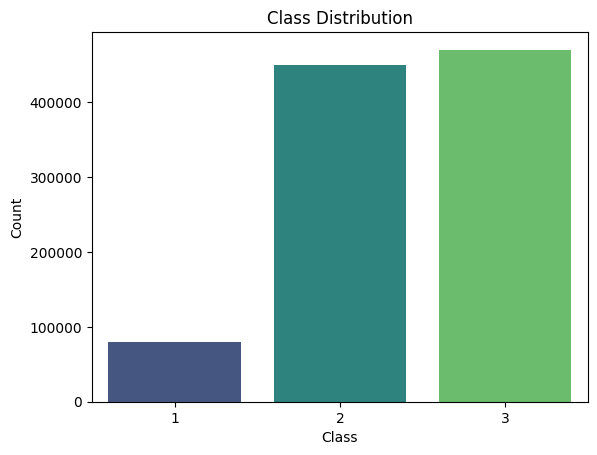

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot for the Class column
sns.countplot(x='Class', data=cleaned_df, palette='viridis')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

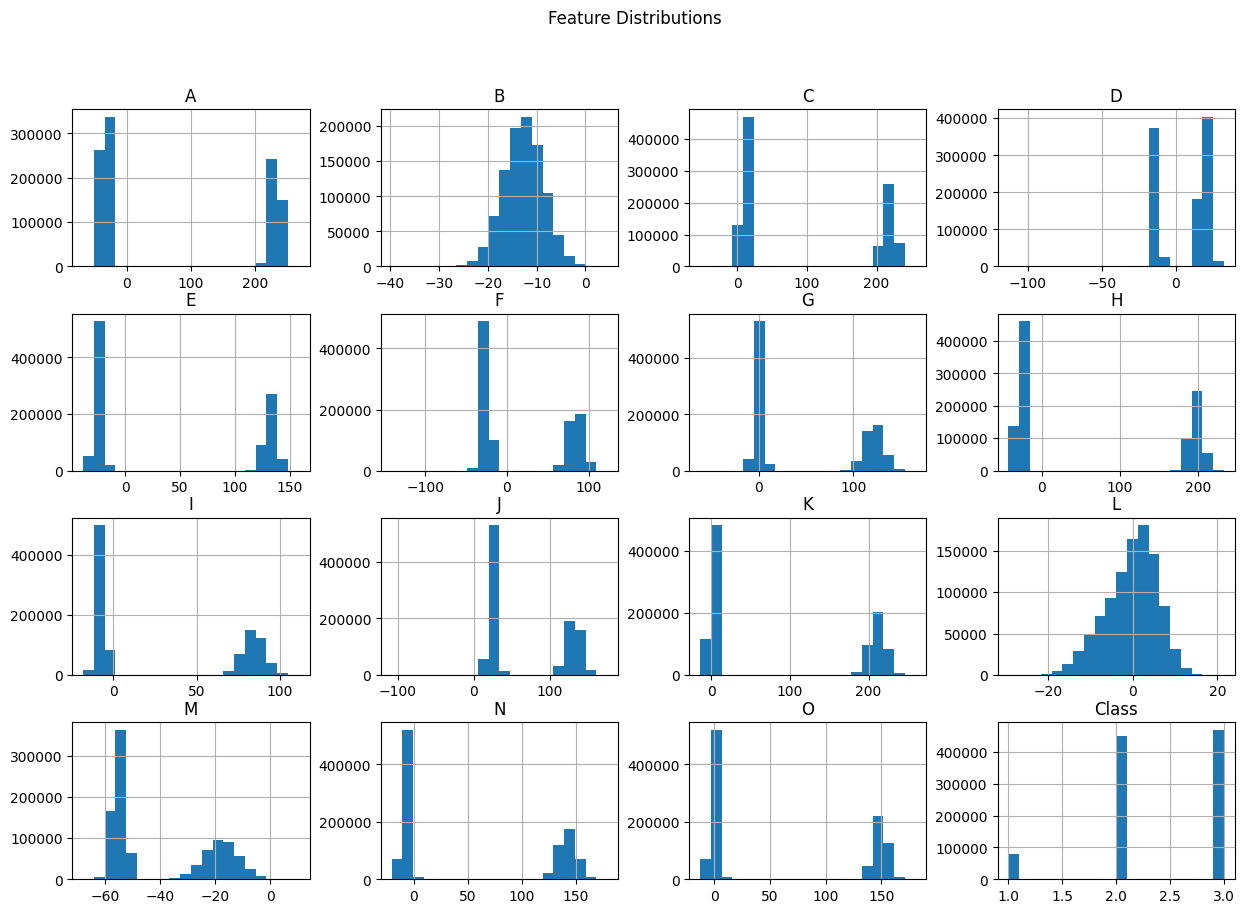

<ipython-input-17-2411e4f61e7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cleaned_df[column], palette='viridis')


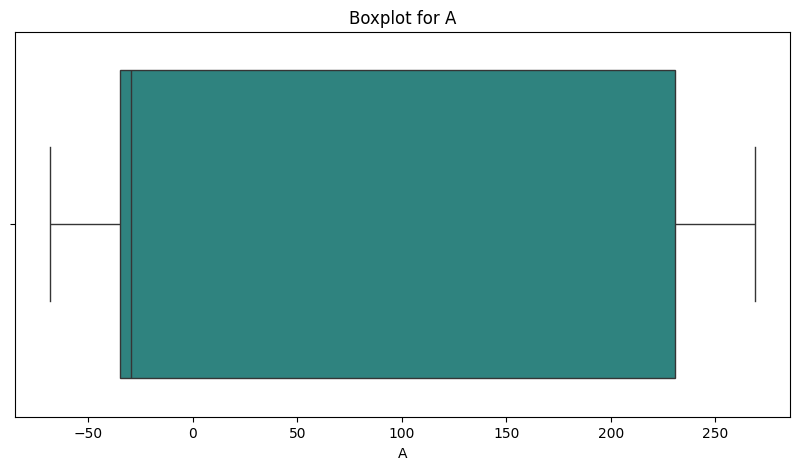

<ipython-input-17-2411e4f61e7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cleaned_df[column], palette='viridis')


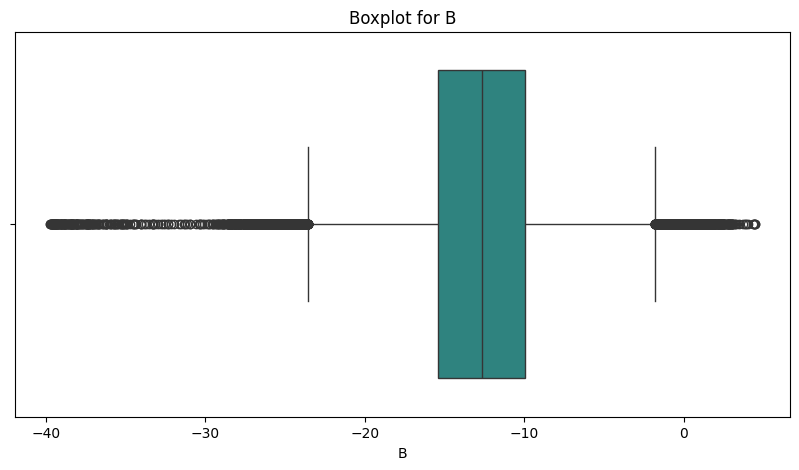

<ipython-input-17-2411e4f61e7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cleaned_df[column], palette='viridis')


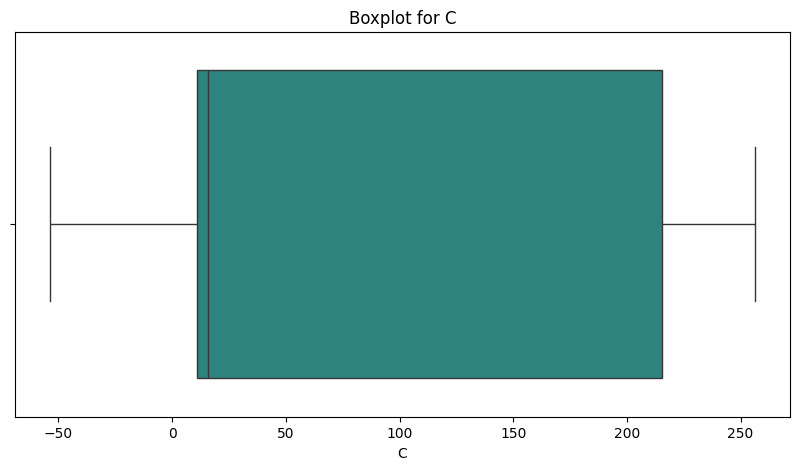

<ipython-input-17-2411e4f61e7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cleaned_df[column], palette='viridis')


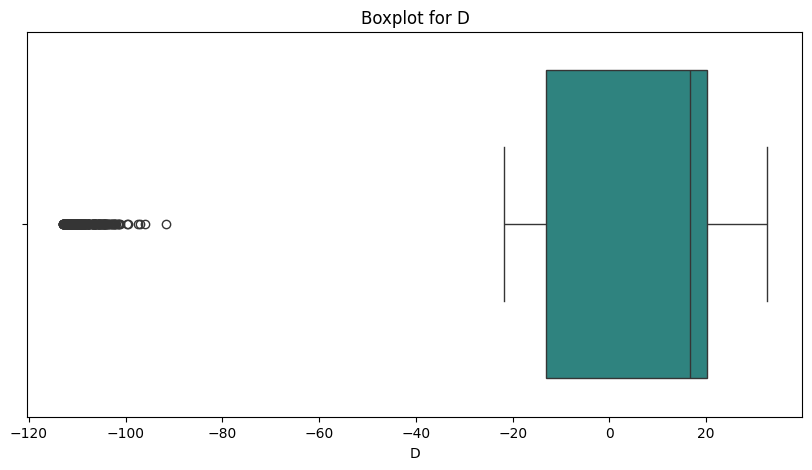

<ipython-input-17-2411e4f61e7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cleaned_df[column], palette='viridis')


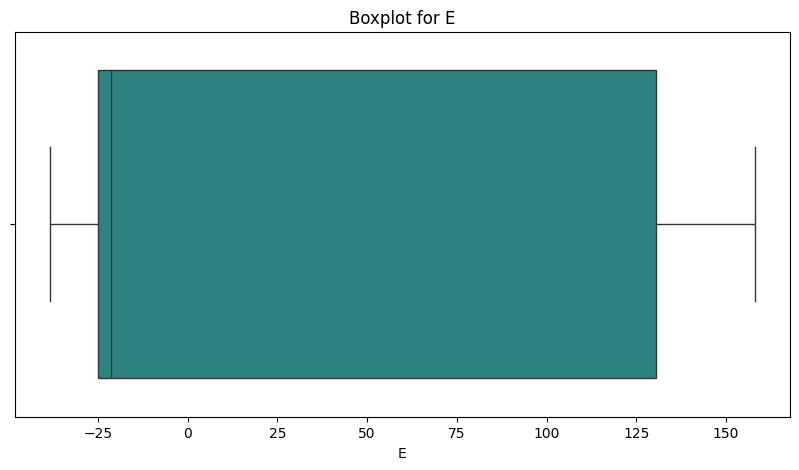

<ipython-input-17-2411e4f61e7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cleaned_df[column], palette='viridis')


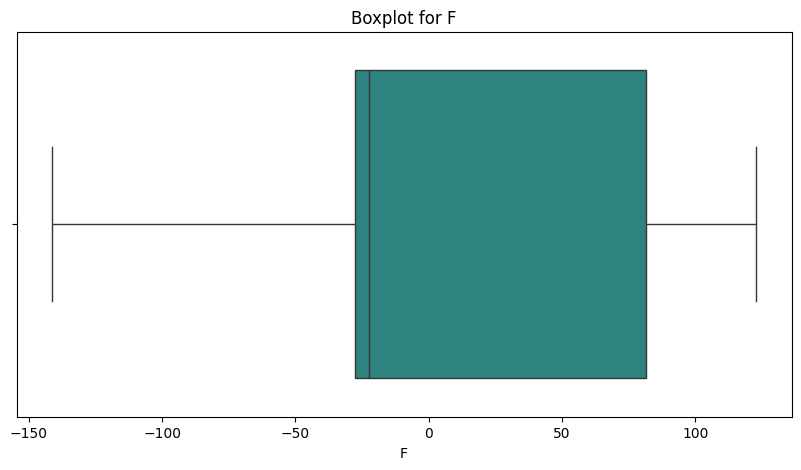

<ipython-input-17-2411e4f61e7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cleaned_df[column], palette='viridis')


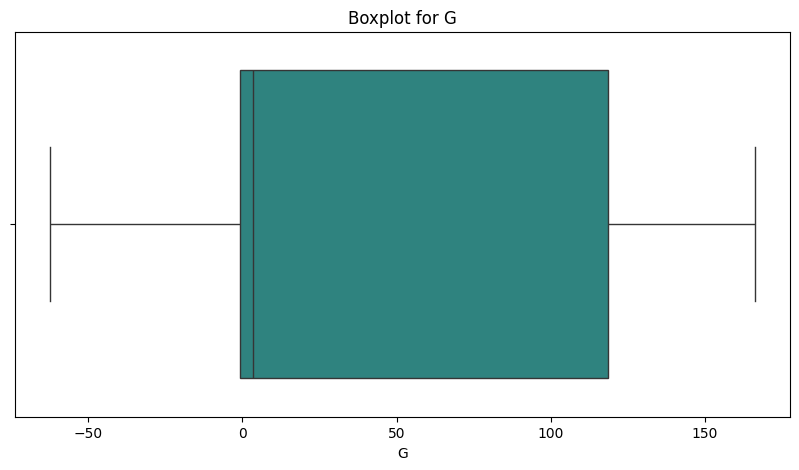

<ipython-input-17-2411e4f61e7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cleaned_df[column], palette='viridis')


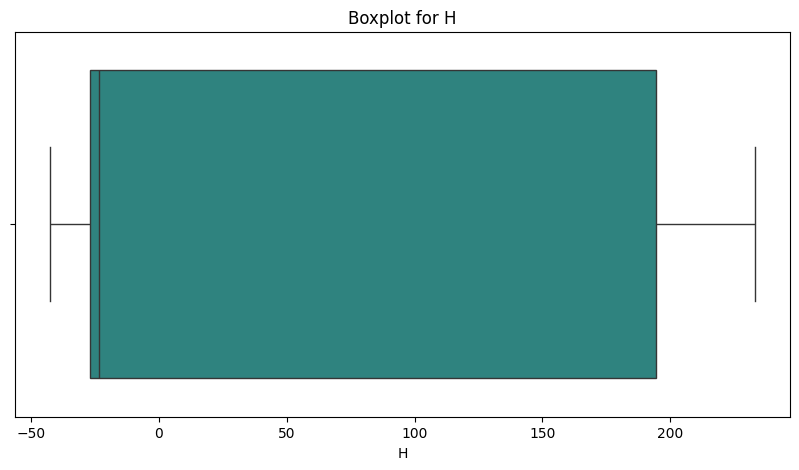

<ipython-input-17-2411e4f61e7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cleaned_df[column], palette='viridis')


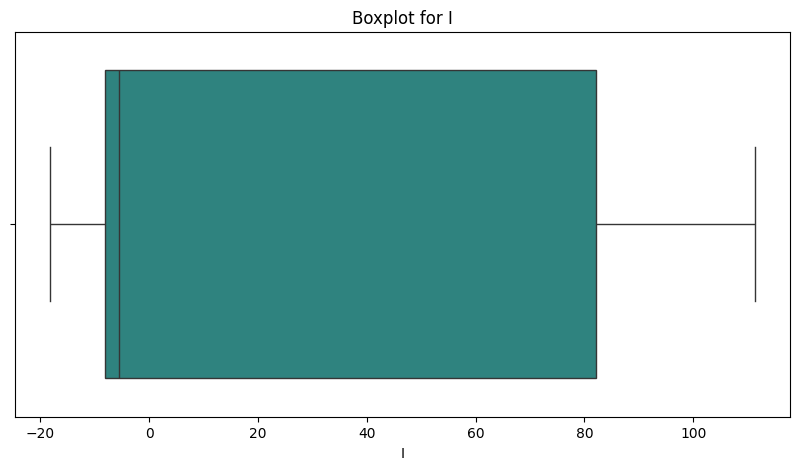

<ipython-input-17-2411e4f61e7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cleaned_df[column], palette='viridis')


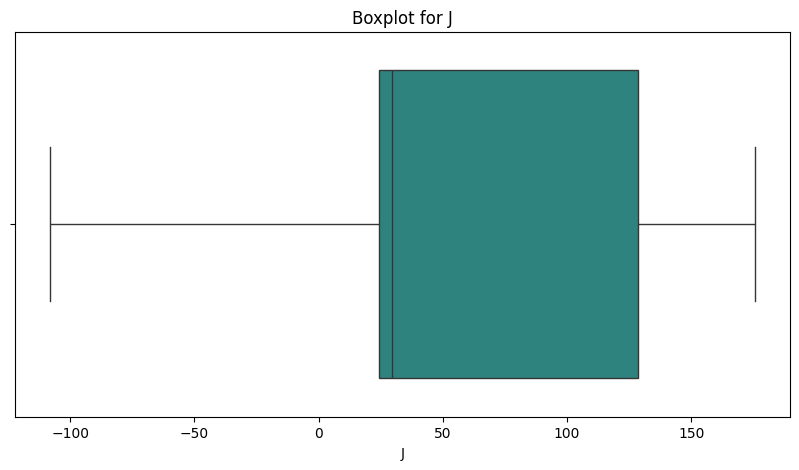

<ipython-input-17-2411e4f61e7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cleaned_df[column], palette='viridis')


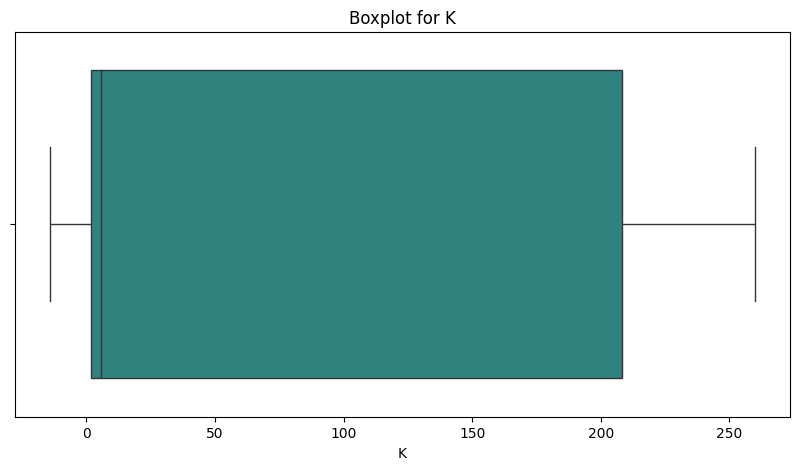

<ipython-input-17-2411e4f61e7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cleaned_df[column], palette='viridis')


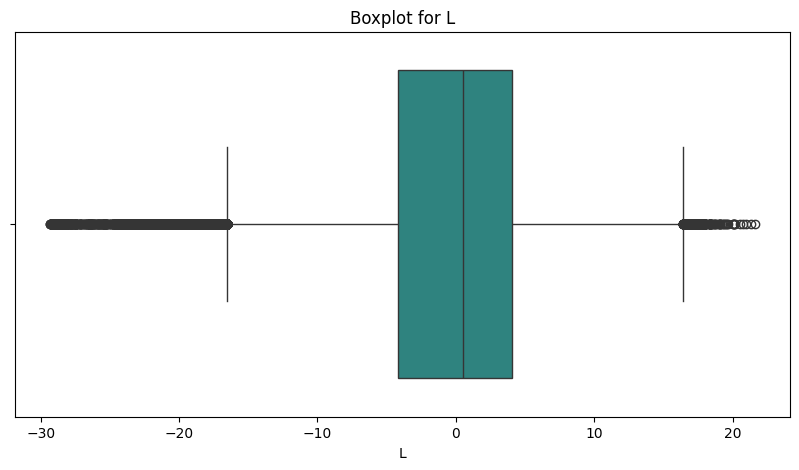

<ipython-input-17-2411e4f61e7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cleaned_df[column], palette='viridis')


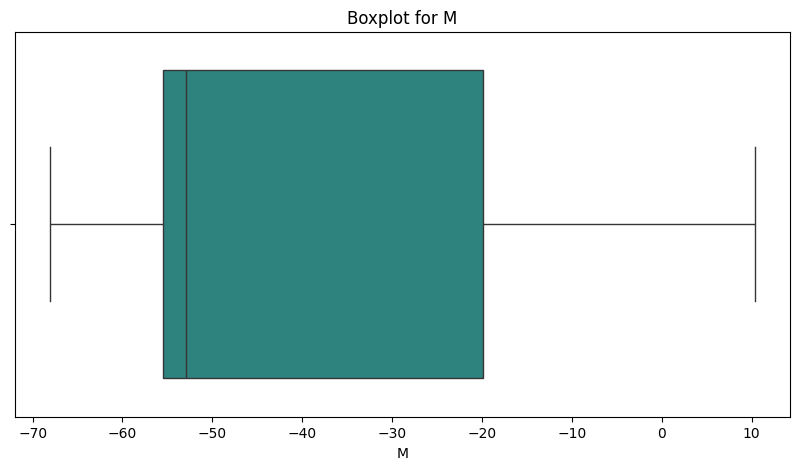

<ipython-input-17-2411e4f61e7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cleaned_df[column], palette='viridis')


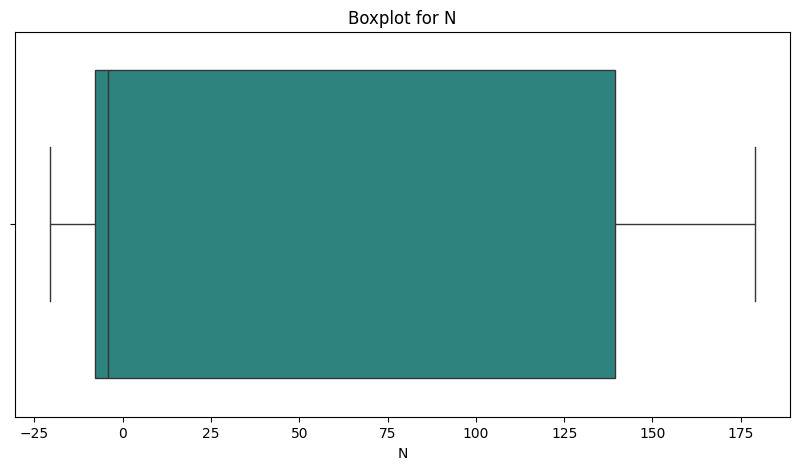

<ipython-input-17-2411e4f61e7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cleaned_df[column], palette='viridis')


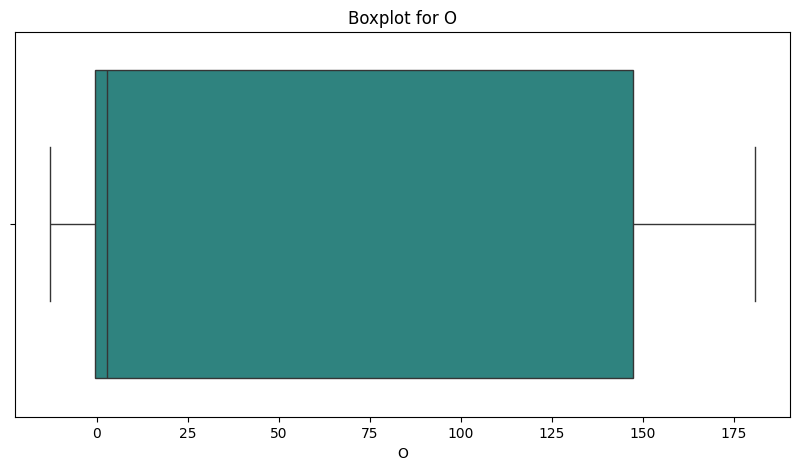

In [17]:
# Histograms for numerical columns
cleaned_df.hist(figsize=(15, 10), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

# Boxplots for numerical features
for column in cleaned_df.columns[:-1]:  # Exclude 'Class'
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=cleaned_df[column], palette='viridis')
    plt.title(f"Boxplot for {column}")
    plt.show()

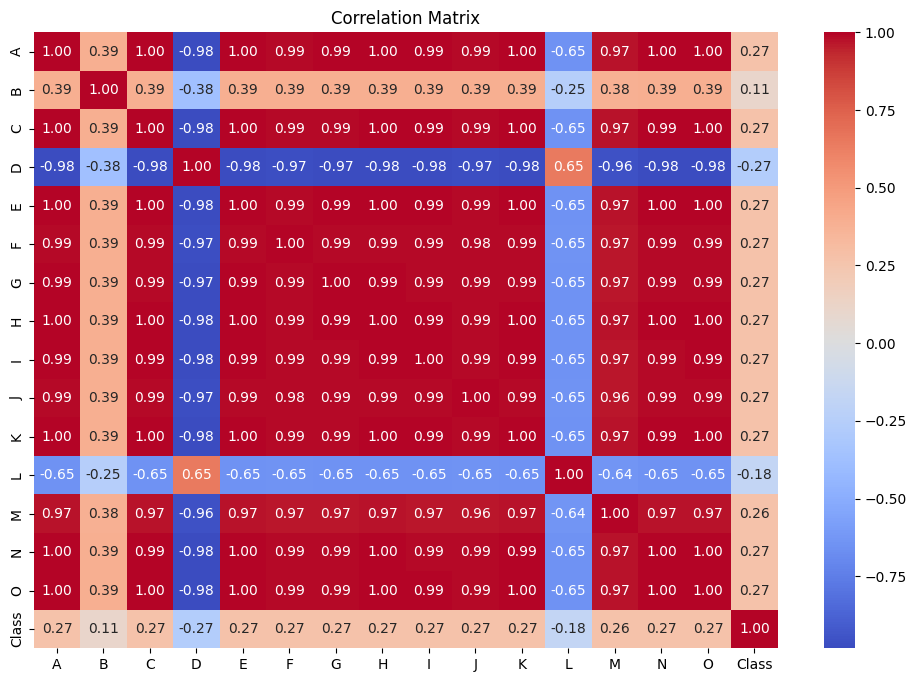

In [18]:
# Compute correlation matrix
correlation_matrix = cleaned_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
# Create a smaller sample (20% of original data)
sample_df = cleaned_df.sample(frac=0.2, random_state=42)

In [21]:
# Separate features and target
X = sample_df.drop('Class', axis=1)
y = sample_df['Class']

In [22]:
# Split the sampled data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# Create and fit the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [32]:
print(classification_report(pipeline.predict(X_train),
                            y_train))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     12874
           2       1.00      1.00      1.00     71918
           3       1.00      1.00      1.00     75224

    accuracy                           1.00    160016
   macro avg       1.00      1.00      1.00    160016
weighted avg       1.00      1.00      1.00    160016



In [33]:
pipeline.predict(X_test)

array([2, 3, 3, ..., 3, 3, 2])

In [34]:
y_test.values.ravel()

array([2, 1, 3, ..., 3, 3, 2])

In [35]:
print(classification_report(pipeline.predict(X_test),
                            y_test))

              precision    recall  f1-score   support

           1       0.00      0.83      0.00         6
           2       1.00      0.75      0.86     23921
           3       0.68      0.80      0.74     16078

    accuracy                           0.77     40005
   macro avg       0.56      0.79      0.53     40005
weighted avg       0.87      0.77      0.81     40005



In [37]:
input_types = dict([(x, FloatTensorType([None, 1])) for x in X_train.columns.values])

try:
    model_onnx = convert_sklearn(pipeline,
                                 'pipeline_rf_classifier_onnx',
                                initial_types=list(input_types.items()))
except Exception as e:
    print(e)

with open("rf_classifier.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

In [38]:
inputs_onnx = {k: np.array(v).astype(np.float32)[:, np.newaxis] for k, v in X_test.to_dict(orient='list').items()}

session_onnx = rt.InferenceSession("rf_classifier.onnx")
predict_onnx = session_onnx.run(None, inputs_onnx)
print("predict", predict_onnx[0])

predict [2 3 3 ... 3 3 2]


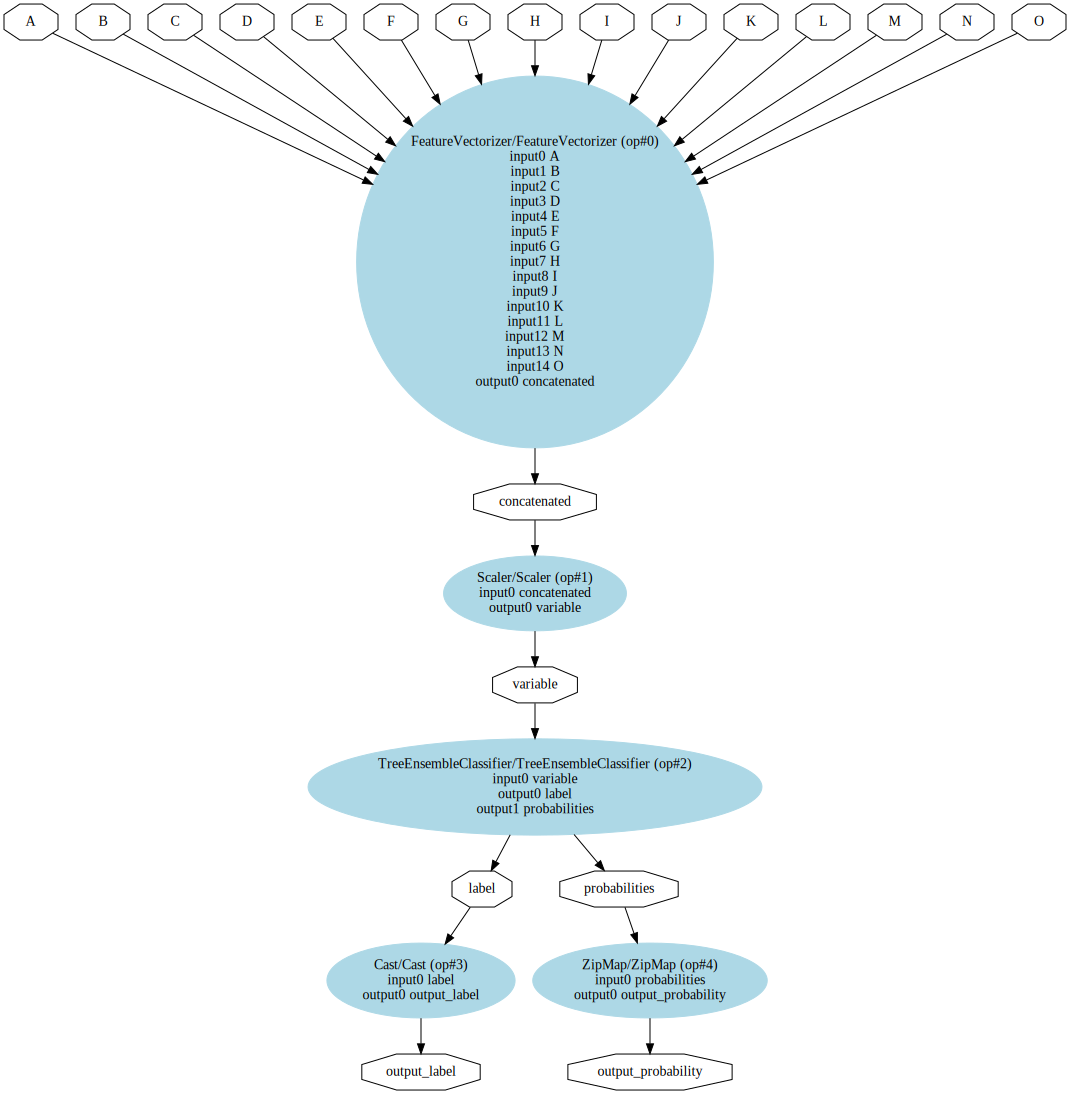

In [41]:
pydot_graph = GetPydotGraph(model_onnx.graph,
                            name=model_onnx.graph.name,
                            rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring",
                                                            color="lightblue",
                                                            fillcolor="lightblue",
                                                            style="filled"))

graphviz.Source(pydot_graph.to_string())